# K Means Clustering

In [8]:
from sklearn.datasets import make_blobs
import sklearn
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

In [9]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [10]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

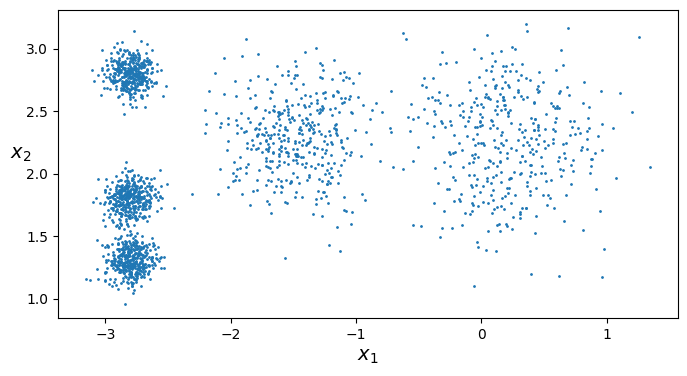

In [12]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

In [13]:
from sklearn.cluster import KMeans

In [14]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

In [15]:
# It defines labels for each data item which shows the cluster label that the data item belongs to 
y_pred


array([2, 2, 4, ..., 1, 4, 2], shape=(2000,), dtype=int32)

In [16]:
y_pred is kmeans.labels_

True

In [17]:
kmeans.cluster_centers_

array([[-0.066884  ,  2.10378803],
       [-2.79290307,  2.79641063],
       [-2.80214068,  1.55162671],
       [-1.47468607,  2.28399066],
       [ 0.47042841,  2.41380533]])

In [18]:
kmeans.labels_

array([2, 2, 4, ..., 1, 4, 2], shape=(2000,), dtype=int32)

In [22]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([0, 4, 1, 1], dtype=int32)

### Decision Boundaries

Let's plot the model's decision boundaries. This gives us a Voronoi diagram:

In [19]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

NameError: name 'save_fig' is not defined

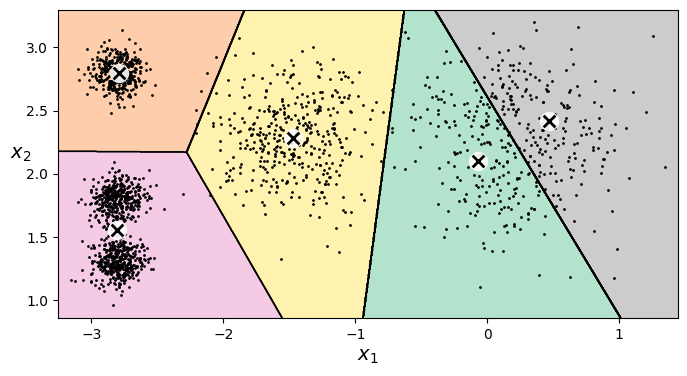

In [20]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

In [32]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

### Hard Clustering vs Soft Clustering

Rather than arbitrarily choosing the closest cluster for each instance, which is called hard clustering, it might be better to measure the distance of each instance to all 5 centroids. This is what the transform() method does

In [23]:
kmeans.transform(X_new)

array([[0.12347236, 2.9042344 , 2.83778629, 1.50178217, 0.62652832],
       [3.06863967, 5.84739223, 5.81943941, 4.48368889, 2.56319474],
       [3.06697984, 0.29040966, 1.4618254 , 1.685008  , 3.51958769],
       [2.95975563, 0.36159148, 0.96879317, 1.54053323, 3.47149865]])

### How does K-Means actually work
So how does the algorithm work? Well it is really quite simple. Suppose you were given the centroids: you could easily label all the instances in the dataset by assigning each of them to the cluster whose centroid is closest. Conversely, if you were given all
the instance labels, you could easily locate all the centroids by computing the mean of the instances for each cluster. But you are given neither the labels nor the centroids, so how can you proceed? Well, just start by placing the centroids randomly (e.g., by
picking k instances at random and using their locations as centroids). Then label the instances, update the centroids, label the instances, update the centroids, and so on until the centroids stop moving. The algorithm is guaranteed to converge in a finite number of steps (usually quite small), it will not oscillate forever2

## Centroid Initialization Methods
Unfortunately, although the algorithm is guaranteed to converge, it may not converge to the right solution (i.e., it may converge to a local optimum): this depends on thecentroid initialization. If you happen to know approximately where the centroids should be (e.g., if you ran
another clustering algorithm earlier), then you can set the init hyperparameter to a NumPy array containing the list of centroids, and set n_init to 1:

In [26]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)


KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=1, random_state=42)

In [27]:
kmeans.inertia_

211.59853725816836

### Accelerated K-Means
The K-Means algorithm can be significantly accelerated by avoiding many unnecessary distance calculations: this is achieved by exploiting the triangle inequality (given three points A, B and C, the distance AC is always such that AC ≤ AB + BC) and by keeping track of lower and upper bounds for distances between instances and centroids 

### Mini Batch K-Means
Instead of using the full dataset at each iteration, the algorithm is capable of using mini-batches, moving the centroids just slightly at each iter ation. This speeds up the algorithm typically by a factor of 3 or 4 and makes it possible to cluster huge datasets that do not fit in memory. Scikit-Learn implements this algorithm in the MiniBatchKMeans class.

In [28]:
from sklearn.cluster import MiniBatchKMeans

In [29]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5, random_state=42)

In [30]:
minibatch_kmeans.inertia_

211.65945105712615

### Finding the optimal number of clusters

Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. So, interia is not a good performance metrics when it comes to selecting the value for k.

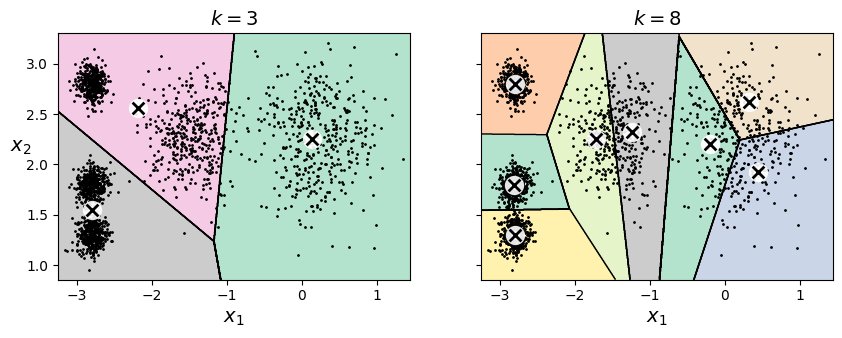

In [34]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
plt.show()

In [35]:
kmeans_k8.inertia_

127.13141880461836

In [36]:
kmeans_k3.inertia_

653.2167190021553

# Using Clustering for Image Segmentation

In [42]:
import urllib.request
import os

In [43]:
# Download the ladybug image
images_path = os.path.join("/Users/karthikathota/Documents/Github/AI/ML", "images", "unsupervised_learning")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "ladybug.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('/Users/karthikathota/Documents/Github/AI/ML/images/unsupervised_learning/ladybug.png',
 <http.client.HTTPMessage at 0x108323750>)

In [44]:
from matplotlib.image import imread
image = imread(os.path.join(images_path, filename))
image.shape

(533, 800, 3)

In [45]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [46]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

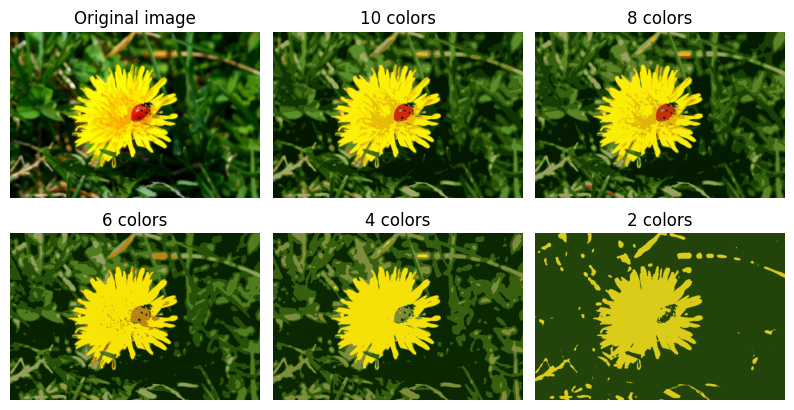

In [48]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

plt.show()